<a href="https://colab.research.google.com/github/bsmiron/cats_and_dogs/blob/main/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==2.5

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
!nvidia-smi

In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow

import cv2
import numpy as np
import pandas as pd

from tensorflow import keras

from keras_preprocessing.image import load_img
# from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
from matplotlib import gridspec

import random
import os

In [ ]:
Image_Width=64
Image_Height=64
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [ ]:
path_train = os.listdir('/content/drive/MyDrive/Data/cats_vs_dogs/train')

# Setting the categories
category = []

for images in path_train:

    # img = cv2.imread(f'{images}')
    # img= cv2.cvtColor(img, )
    # cv2_imshow(img)
    # img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

    images.split('.')
    # print(images.split('.')[1])
    if images.split('.')[0] == 'dog':
        category.append(0) #dogs
        
    else:
        category.append(1) #cats
        

# Create a data frame saying which image is what category dog/cat 
df=pd.DataFrame({
    'images':path_train,
    'category':category
})

In [ ]:
df['category'] = df['category'].replace({0:'dog', 1:'cat'})
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(val_df)

In [ ]:
total_train = train_df.shape[0]
total_val = val_df.shape[0]
print(total_train)
print(total_val)

batch_size = 15

In [ ]:
train_df.head()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing

model = keras.Sequential([
    
    # Input Layer
    layers.InputLayer(input_shape=[Image_Width, Image_Height, Image_Channels]),

    # Block 1
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=1),
    layers.MaxPool2D(pool_size=2),
    layers.Dropout(0.25),

    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=1),
    layers.MaxPool2D(pool_size=2),
    layers.Dropout(0.25),

    # Fully connected
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax'),
    # 128 relu neurons 
    # 2 binary neurons for classification

    ])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [ ]:
model.summary()

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/Data/cats_vs_dogs/train",
    x_col='images',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
    )


validation_datagen = ImageDataGenerator(rescale=1./255)

val_generator = validation_datagen.flow_from_dataframe(
    val_df,
    "/content/drive/MyDrive/Data/cats_vs_dogs/train",
    x_col='images',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
    )

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

# test_generator = train_datagen.flow_from_dataframe(
#      train_df,
#     "/content/drive/MyDrive/Data/cats_vs_dogs/test1",
#     x_col='images',
#     y_col='category',
#     target_size=Image_Size,
#     class_mode='categorical',
#     batch_size=1
#     )

test_generator = train_datagen.flow_from_dataframe(
     train_df,
    "/content/drive/MyDrive/Data/cats_vs_dogs/test1",
    x_col='images',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=1
    )

In [ ]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.001)

model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy'],
)

history = model.fit_generator(
    # insert data -> train folder or df
    train_generator,
    # insert test folder/validation df
    validation_data = val_generator,
    validation_steps = total_val//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks,
    # first epochs used in paper was  
    epochs = 25,
    # epochs = 50,  

)

In [ ]:
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
# warnings.filterwarnings("ignore") # to clean up output cells

In [ ]:
# Plot learning curves
import pandas as pd
# print(history.history)
history_frame = pd.DataFrame.from_dict(history.history, orient='index')
history_frame = history_frame.transpose()
print(history_frame)
# print(history_frame)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
model.save("model1_catsVSdogs_10epoch.h5")

In [ ]:
test_filenames = os.listdir("/content/drive/MyDrive/Data/cats_vs_dogs/test1")
test_df = pd.DataFrame({
    'images': test_filenames
})
print(test_df)
nb_samples = test_df.shape[0]
# print(nb_samples)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = train_datagen.flow_from_dataframe(
     test_df,
    "/content/drive/MyDrive/Data/cats_vs_dogs/test1",
    x_col='images',
    y_col=None,
    target_size=Image_Size,
    class_mode=None,
    batch_size=batch_size
    )

print(test_generator)

In [ ]:
predict = model.predict(test_generator, nb_samples/batch_size)

In [ ]:
classes_x=np.argmax(predict,axis=1)
print(classes_x)

In [ ]:
dogs = 0
cats = 0
for ind in classes_x:
  if ind == 0:
    cats += 1
  else:
    dogs += 1
print(cats)
print(dogs)

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
# test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

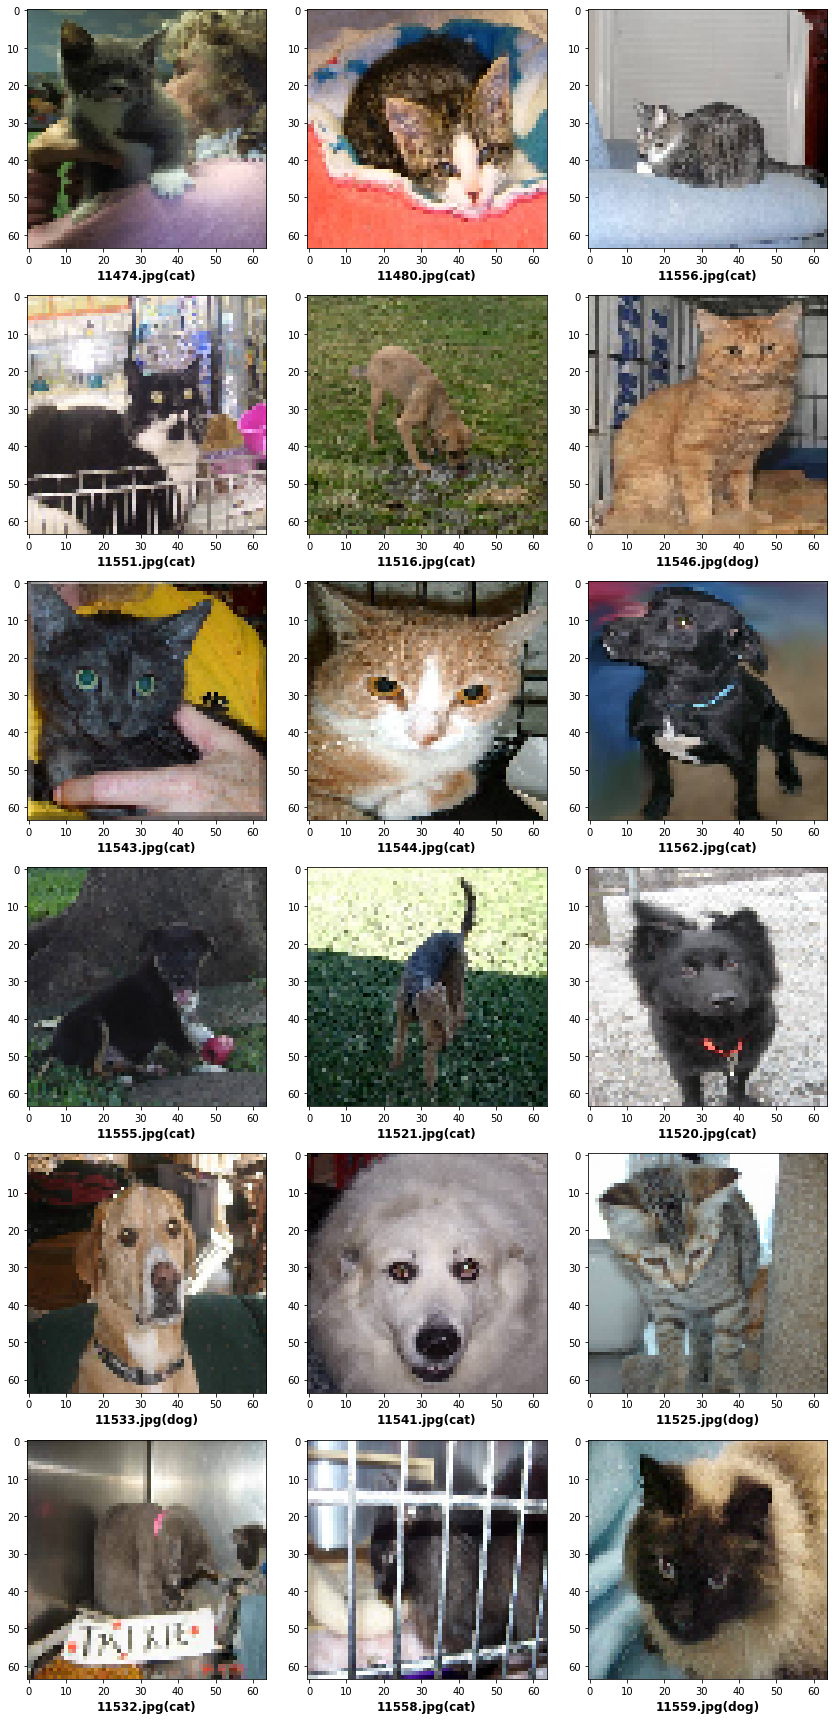

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    # print(index)
    # print(row)
    filename = row['images']
    # print(filename)
    category = row['category']
    img = load_img("/content/drive/MyDrive/Data/cats_vs_dogs/test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()